### Library

In [1]:
import os
import time
import random
import timm
import torch
import cv2
import albumentations as A
import pandas as pd
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score

In [2]:
def random_seed(SEED=42):
    # SEED = 42 # default
    os.environ['PYTHONHASHSEED'] = str(SEED)
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True

random_seed()

### Load Data

In [3]:
train_label_path = "../../data/train.csv"
meta_data_path = "../../data/meta.csv"

train_label = pd.read_csv(train_label_path)
meta_data = pd.read_csv(meta_data_path)
train_labels = pd.merge(train_label, meta_data, on="target", how="left")

train_labels = train_labels[['ID', 'class_name', 'target']]
train_labels

,ID,class_name,target
0,002f99746285dfdd.jpg,vehicle_registration_plate,16
1,008ccd231e1fea5d.jpg,payment_confirmation,10
2,008f5911bfda7695.jpg,payment_confirmation,10
3,009235e4c9c07af5.jpg,diagnosis,4
4,00b2f44967580c74.jpg,vehicle_registration_plate,16
...,...,...,...
1565,fed9e9ec4a77bc06.jpg,diagnosis,4
1566,feeade617aa68c45.jpg,medical_outpatient_certificate,7
1567,ff51dd281a8423f1.jpg,pharmaceutical_receipt,11
1568,ff8a6a251ce51c95.jpg,driver_lisence,5


In [4]:
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1570 entries, 0 to 1569
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ID          1570 non-null   object
 1   class_name  1570 non-null   object
 2   target      1570 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 36.9+ KB


In [5]:
class ImageDataset(Dataset):
    def __init__(self, csv, path, transform=None):
        self.df = pd.read_csv(csv).values
        self.path = path
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)))
        if self.transform:
            img = self.transform(image=img)['image']
        return img, target

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_path = '../../data/train/'

train_dataset = ImageDataset(
    csv=f"{train_label_path}",
    path=f"{data_path}/train/",
)

print(len(train_dataset))

1570


### EDA

In [7]:
# Count_plot
def count_plot(df, col, figsize=(10, 6), palette="Blues_r", rotation=None, title=None, xlabel=None, ylabel='Count'):
    plt.figure(figsize=figsize)
    sns.countplot(data=df, x=col, palette=palette)
    plt.title(title if title else f'{col} Count')
    plt.xticks(rotation=rotation)
    plt.xlabel(xlabel if xlabel is not None else col)
    plt.ylabel(ylabel)
    plt.show()

# hist plot
def hist_plot(df1, col, df2=None, figsize=(8, 6), bins=30, alpha=0.6, color1='skyblue', color2='salmon', label1=None, label2=None, title=None):
    plt.figure(figsize=figsize)

    # 개별 데이터 프레임
    sns.histplot(df1[col], kde=True, bins=bins, alpha=alpha, color=color1, label=label1 if label1 else ('Group 1' if df2 is not None else None))
    if df2 is not None: # 두 그룹 비교
        sns.histplot(df2[col], kde=True, bins=bins, alpha=alpha, color=color2, label=label2 if label2 else 'Group 2')
        plt.legend()  # 두 그룹일 때만 범례 표시

    plt.title(title if title else f'{col} Distribution (Histogram + KDE)')
    plt.xlabel(col)
    plt.show()

# bar plot    
def bar_plot(df, x_col, y_col, figsize=(10, 6), hue=None, palette="Blues_r", rotation=None, title=None, xlabel=None, ylabel=None):
     plt.figure(figsize=figsize)
     
     if hue: # hue 지정
        sns.barplot(x=x_col, y=y_col, hue=hue, data=df, palette=palette)
     else: # hue 지정 X
        sns.barplot(x=x_col, y=y_col, data=df, palette=palette)

     plt.xticks(rotation=rotation)
     plt.title(title)
     plt.xlabel(xlabel)
     plt.ylabel(ylabel)
     plt.show()

- Class_Imbalance

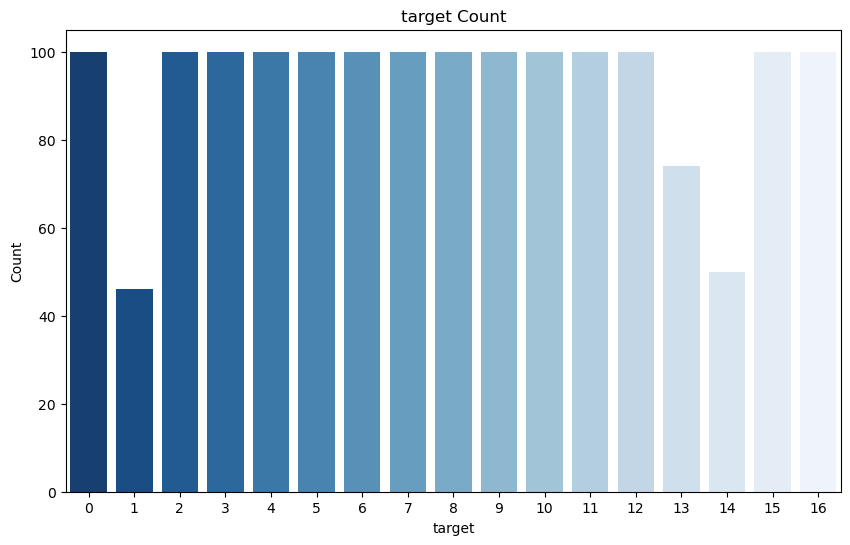

In [18]:
# Class check
count_plot(df=train_labels, col='target')

In [9]:
class_imbalance = train_label[train_label['target'].isin([1, 13, 14])]['target'].unique().tolist()
class_imbalance

# imbalance_col = class_imbalance['class_name'].unique().tolist()
# imbalance_col

[14, 13, 1]

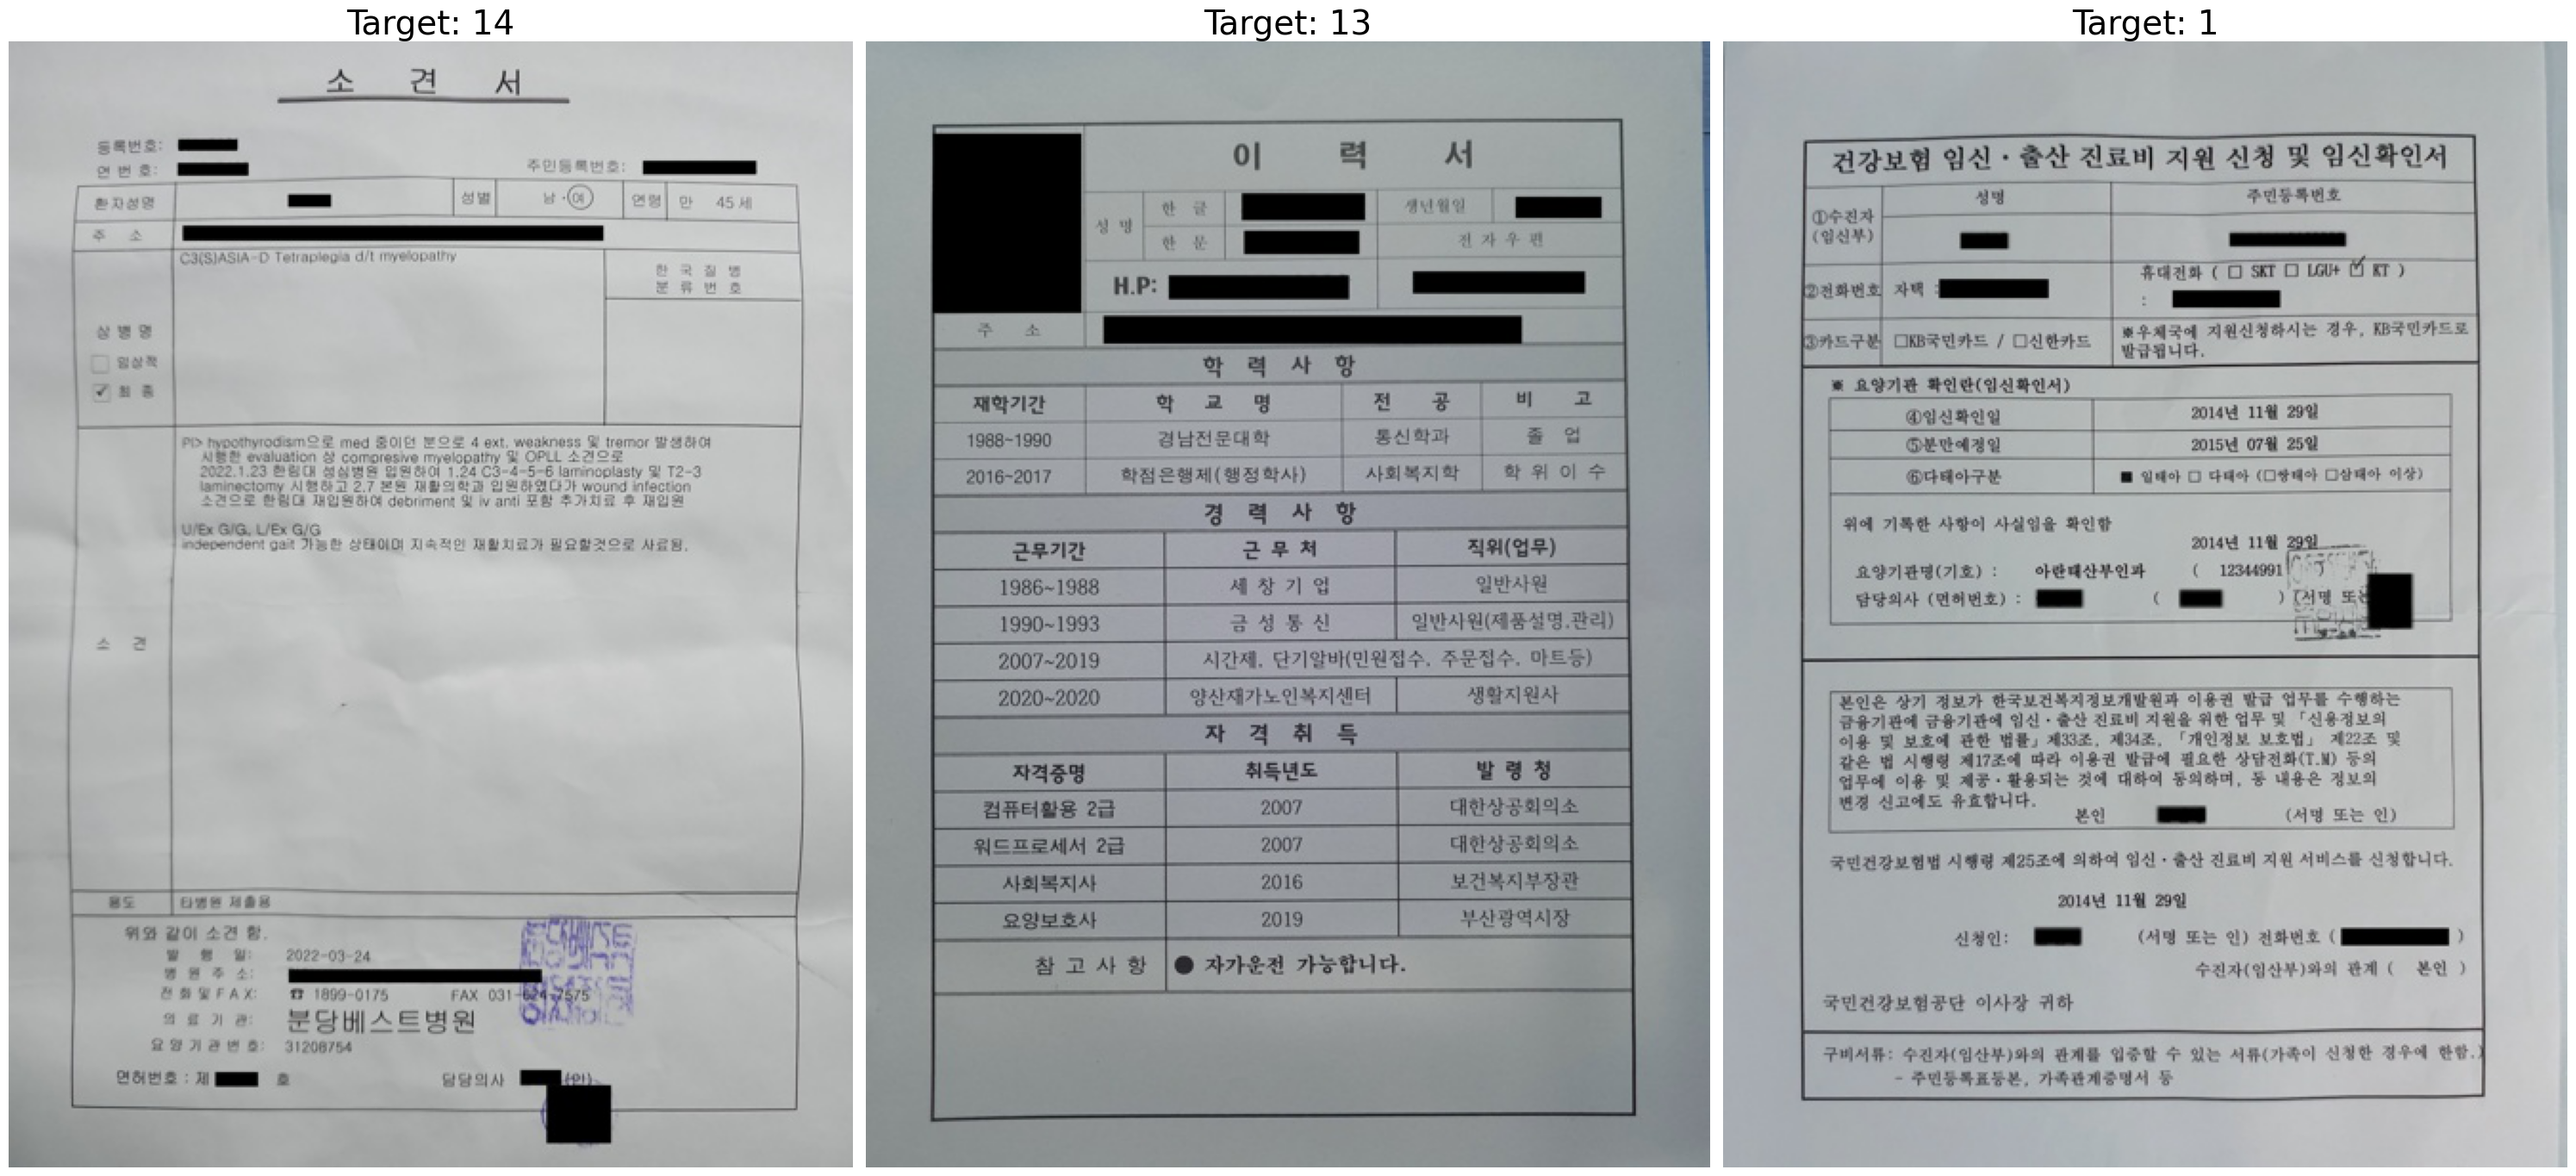

In [10]:
fig, axes = plt.subplots(1, len(class_imbalance), figsize=(10 * len(class_imbalance), 15))

for ax, target in zip(axes, class_imbalance):
    subset = train_label[train_label['target'] == target]
    sample_row = subset.sample(1).iloc[0]
    img_name = sample_row.iloc[0]  # ID Column
    img_path = os.path.join(data_path, img_name)
    
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(f"Target: {sample_row['target']}", fontsize=28)
    ax.axis('off')

plt.tight_layout()
plt.show()

- Blur Check

In [11]:
variances = []

for idx, row in tqdm(train_label.iterrows(), total=len(train_label)):
    img_name = row.iloc[0]  # ID Column
    img_path = os.path.join(data_path, img_name)
    
    img_cv = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img_cv is None:
        print(f"이미지 로드 실패: {img_path}")
        continue
    
    variance = cv2.Laplacian(img_cv, cv2.CV_64F).var()
    variances.append({
        "img_name": img_name,
        "target": row["target"],
        "variance": variance # 값이 클수록 선명함
    })

blur = pd.DataFrame(variances)
blur

100%|██████████| 1570/1570 [00:02<00:00, 620.89it/s]


,img_name,target,variance
0,002f99746285dfdd.jpg,16,4461.719775
1,008ccd231e1fea5d.jpg,10,1630.437757
2,008f5911bfda7695.jpg,10,3522.353811
3,009235e4c9c07af5.jpg,4,1140.816877
4,00b2f44967580c74.jpg,16,1590.176746
...,...,...,...
1565,fed9e9ec4a77bc06.jpg,4,1478.417648
1566,feeade617aa68c45.jpg,7,1054.485550
1567,ff51dd281a8423f1.jpg,11,2019.669529
1568,ff8a6a251ce51c95.jpg,5,941.559549


In [15]:
blur[['variance']].describe()

,variance
count,1570.000000
mean,1358.170567
std,822.036554
min,70.042379
25%,767.158727
50%,1199.573751
75%,1795.379881
max,4955.884694


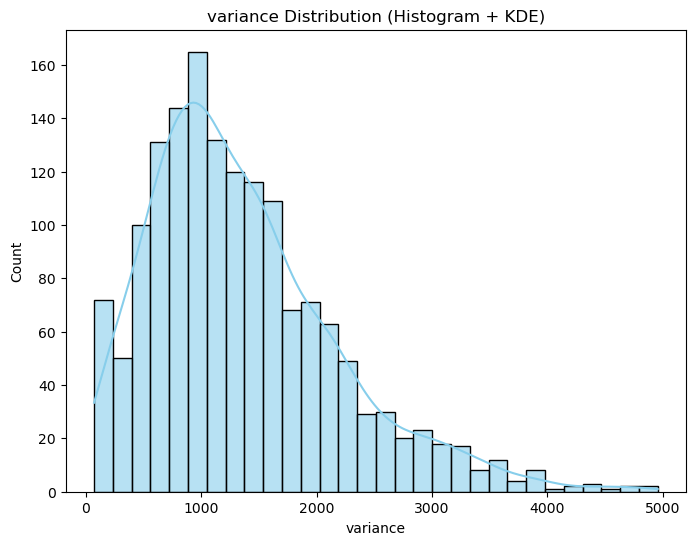

흐릿한 이미지 샘플 개수: 393


In [16]:
threshold = blur['variance'].quantile(0.25) # 25% 분위수: 767
blurry_samples = blur[blur['variance'] < threshold]

hist_plot(df1=blur, col='variance')
print(f"흐릿한 이미지 샘플 개수: {len(blurry_samples)}")

- Masking Check

In [23]:
masking_stats = []

for idx, row in tqdm(train_label.iterrows(), total=len(train_label)):
    img_name = row.iloc[0]  # ID Column (이미지 파일명)
    img_path = os.path.join(data_path, img_name)
    
    img_cv = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img_cv is None:
        print(f"이미지 로드 실패: {img_path}")
        continue
    
    black_pixels = np.sum(img_cv == 0)
    black_ratio = black_pixels / (img_cv.shape[0] * img_cv.shape[1])
    
    masking_stats.append({
        "img_name": img_name,
        "target": row["target"],
        "black_ratio": black_ratio # 이미지 내 마스킹 비율
    })

masking = pd.DataFrame(masking_stats)
masking

100%|██████████| 1570/1570 [00:01<00:00, 957.79it/s] 


,img_name,target,black_ratio
0,002f99746285dfdd.jpg,16,0.003250
1,008ccd231e1fea5d.jpg,10,0.006696
2,008f5911bfda7695.jpg,10,0.006333
3,009235e4c9c07af5.jpg,4,0.018910
4,00b2f44967580c74.jpg,16,0.003976
...,...,...,...
1565,fed9e9ec4a77bc06.jpg,4,0.023773
1566,feeade617aa68c45.jpg,7,0.007608
1567,ff51dd281a8423f1.jpg,11,0.008964
1568,ff8a6a251ce51c95.jpg,5,0.134808


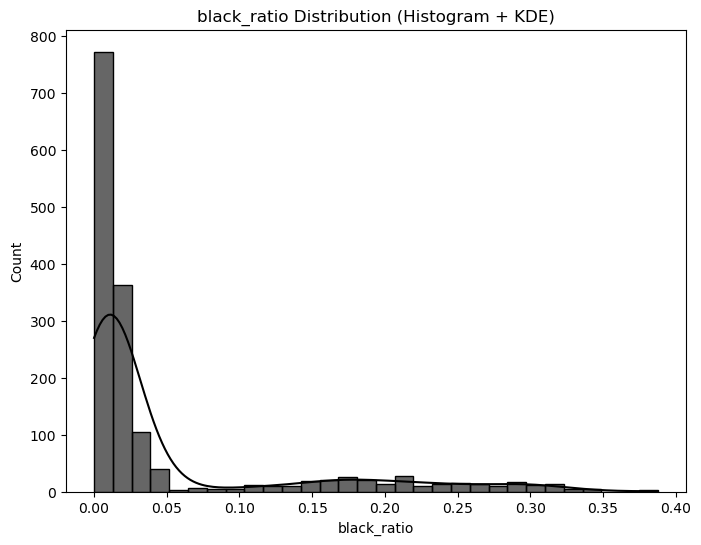

,black_ratio
count,1570.000000
mean,0.048297
std,0.081454
min,0.000000
25%,0.005739
50%,0.013164
75%,0.029747
max,0.387713


In [32]:
hist_plot(df1=masking, col='black_ratio', color1='black')
masking[['black_ratio']].describe()

- 명도 Check

In [31]:
brightness_stats = []

for idx, row in tqdm(train_label.iterrows(), total=len(train_label)):
    img_name = row.iloc[0]  # ID Column
    img_path = os.path.join(data_path, img_name)
    
    img_cv = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img_cv is None:
        print(f"이미지 로드 실패: {img_path}")
        continue
    
    mean_brightness = img_cv.mean()
    
    brightness_stats.append({
        "img_name": img_name,
        "target": row["target"],
        "mean_brightness": mean_brightness # 값이 클수록 이미지가 밝음
    })

brightness = pd.DataFrame(brightness_stats)
brightness

100%|██████████| 1570/1570 [00:01<00:00, 959.37it/s] 


,img_name,target,mean_brightness
0,002f99746285dfdd.jpg,16,112.679065
1,008ccd231e1fea5d.jpg,10,157.959196
2,008f5911bfda7695.jpg,10,160.815399
3,009235e4c9c07af5.jpg,4,145.531395
4,00b2f44967580c74.jpg,16,101.451001
...,...,...,...
1565,fed9e9ec4a77bc06.jpg,4,157.563780
1566,feeade617aa68c45.jpg,7,149.151452
1567,ff51dd281a8423f1.jpg,11,167.814478
1568,ff8a6a251ce51c95.jpg,5,188.081710


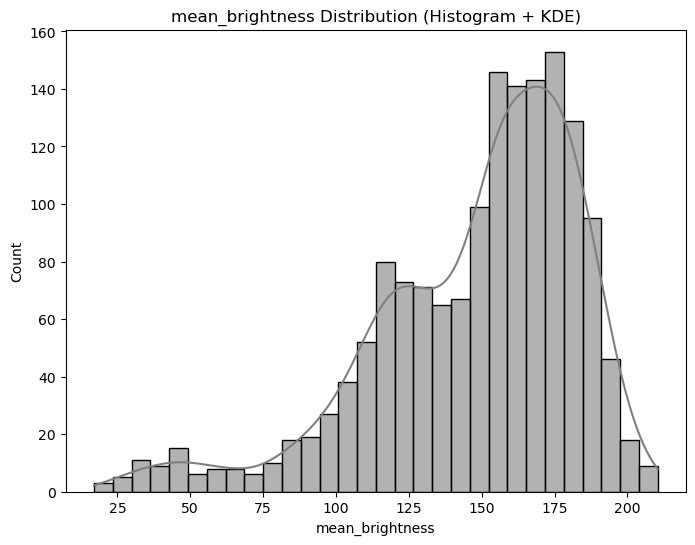

,mean_brightness
count,1570.000000
mean,148.186849
std,35.400525
min,16.989584
25%,126.743481
50%,156.485003
75%,174.019782
max,210.390733


In [33]:
hist_plot(df1=brightness, col='mean_brightness', color1='gray')
brightness[['mean_brightness']].describe()

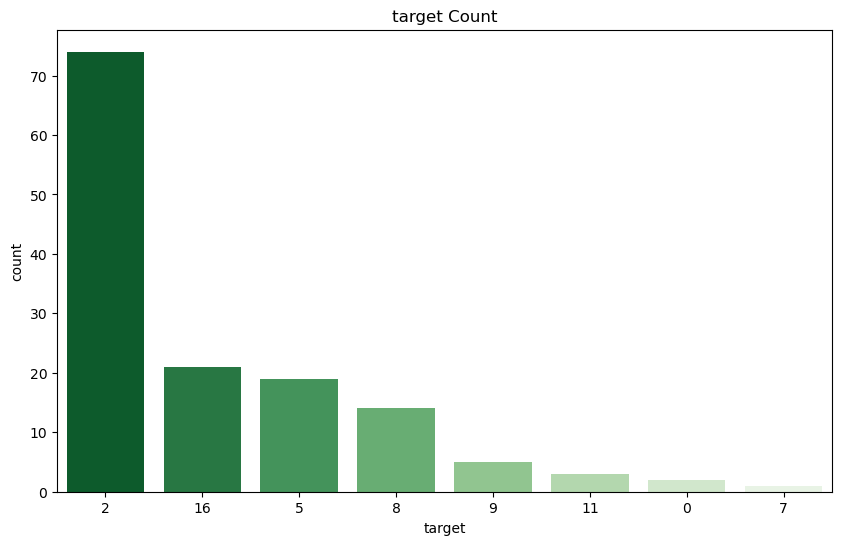

어두운 이미지 샘플 개수: 139


In [43]:
threshold = 100 # Test 기준
brightness_samples = brightness[brightness['mean_brightness'] < threshold]
order = brightness_samples['target'].value_counts().sort_values(ascending=False).index.tolist()

plt.figure(figsize=(10, 6))
sns.countplot(data=brightness_samples, x='target', palette='Greens_r', order=order)
plt.title('target Count')
plt.show()

print(f"어두운 이미지 샘플 개수: {len(brightness_samples)}")